In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import joblib
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
ruta = r"C:\Users\Soporte\Desktop\sabbatic_pred\data\sabbatic_saas_churn_dataset.csv"

df = pd.read_csv(ruta)

# Separar features y target

In [3]:
X = df.drop(columns=['company_id','churn'])
y = df['churn']

# Train / Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

# Escalado de variables
StandardScaler (Poner a todos en la misma escala)

Este paso es puramente matemático pero vital.

El problema: En tus datos tienes tickets_per_month que llega a 3,000 y mobile_usage_ratio que solo llega a 1.0.

El objetivo: Muchos algoritmos de IA creen que "número más grande = más importante". Si no escalas, la IA pensará que los tickets son 3,000 veces más importantes que el uso del móvil solo por el tamaño del número.

El resultado: El StandardScaler transforma todo para que la media sea 0 y la desviación sea 1. Ahora, un "uso alto" de móvil y un "número alto" de tickets se verán iguales ante los ojos de la IA.

In [5]:
scaler = StandardScaler()

X_train_scarler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

# Modelo base: Logistic Regression

In [6]:
log_modelo = LogisticRegression()
log_modelo.fit(X_train_scarler, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

log_modelo.fit(...):  El modelo analiza los datos escalados y busca una relación matemática entre las variables (antigüedad, tickets, etc.) y la probabilidad de churn.

# Evaluación

In [7]:
y_pred = log_modelo.predict(X_test_scaler)
y_proba = log_modelo.predict_proba(X_test_scaler)[:,1]
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93        88
           1       0.33      0.08      0.13        12

    accuracy                           0.87       100
   macro avg       0.61      0.53      0.53       100
weighted avg       0.82      0.87      0.83       100



log_modelo.predict(...): El modelo toma los datos del 20% de clientes que guardamos (X_test) y lanza su apuesta: "Este se queda (0)" o "Este se va (1)".

predict_proba(...): No solo dice 0 o 1, sino que te da la probabilidad exacta (ej. "tengo un 85% de certeza de que se queda"). Esto es útil para campañas de marketing donde solo quieres atacar a los que tengan más de un 90% de riesgo.

Miremos la fila del 1 (Clientes que se van), que es lo que te importa:

Precision	0.33	De cada 100 clientes que el modelo marca como "se van a ir", solo 33 se van realmente. El resto son "falsas alarmas".

Recall	0.08	De todos los clientes que realmente se fueron, el modelo solo detectó al 8%. ¡Se le escaparon el 92% de los fugitivos!

F1-Score	0.13	Es el balance entre los dos anteriores. Un 0.13 es muy bajo; el modelo está sufriendo mucho.

# 1. El Código para implementar SMOTE

In [10]:
# 1. Configuramos SMOTE
smote = SMOTE(random_state=42)

# 2. Aplicamos SMOTE solo a los datos de ENTRENAMIENTO
# ¡Nunca al test! El test debe permanecer real para ser una evaluación honesta.
X_train_res, y_train_res = smote.fit_resample(X_train_scarler, y_train)

print(f"Distribución original: {Counter(y_train)}")
print(f"Distribución tras SMOTE: {Counter(y_train_res)}")

Distribución original: Counter({0: 340, 1: 60})
Distribución tras SMOTE: Counter({0: 340, 1: 340})


In [11]:
# Entrenamos de nuevo la Regresión Logística
log_modelo_smote = LogisticRegression()
log_modelo_smote.fit(X_train_res, y_train_res)

# Predecimos sobre el X_test original (el que no tiene datos sintéticos)
y_pred_smote = log_modelo_smote.predict(X_test_scaler)

print(classification_report(y_test, y_pred_smote))

              precision    recall  f1-score   support

           0       0.95      0.68      0.79        88
           1       0.24      0.75      0.37        12

    accuracy                           0.69       100
   macro avg       0.60      0.72      0.58       100
weighted avg       0.87      0.69      0.74       100



Aquí tienes la interpretación de tus nuevos números:

1. El Gran Salto: El Recall (0.08 ➔ 0.75)

    Antes: Solo detectabas al 8% de los clientes que se iban.

    Ahora: ¡Detectas al 75%!

    Conclusión: El modelo ya no ignora el Churn. Ahora, de cada 12 clientes que realmente se van a ir (en tu set de prueba), el modelo identifica correctamente a 9. Esto es un éxito rotundo para el objetivo de retención.

2. El Sacrificio: La Precision (0.33 ➔ 0.24)

    ¿Qué pasó? Al ser mucho más sensible, el modelo ahora lanza más "falsas alarmas".

    En el negocio: De cada 100 alertas de churn que te da el modelo, solo 24 son reales. Las otras 76 son clientes que probablemente se iban a quedar, pero el modelo los marcó como "sospechosos".

3. La "Caída" de la Accuracy (0.87 ➔ 0.69)

    El Accuracy ha bajado porque el modelo ya no está haciendo la "trampa" de decir siempre que 0 (el grupo mayoritario).

    Prefiere equivocarse un poco más con los clientes que se quedan (grupo 0) para asegurarse de atrapar a los que se van (grupo 1).

# Random Forest (modelo más potente)

In [12]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(X_train_res, y_train_res)

y_pred_rf = rf.predict(X_test_scaler)

print("--- Reporte de Random Forest ---")
print(classification_report(y_test, y_pred_rf))

--- Reporte de Random Forest ---
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        88
           1       0.42      0.42      0.42        12

    accuracy                           0.86       100
   macro avg       0.67      0.67      0.67       100
weighted avg       0.86      0.86      0.86       100



1. El equilibrio perfecto (Balance 0.42 / 0.42)

    En la fila del 1 (Churn). Tiene una Precision de 0.42 y un Recall de 0.42.

    Interpretación: El modelo es mucho más "juicioso". Ha subido la precisión (de 0.24 a 0.42), lo que significa que ahora casi la mitad de sus alertas de churn son reales.

    El intercambio: A cambio de ser más preciso, ha dejado de ser tan "alarmista". Ha pasado de detectar el 75% al 42%. Sigue siendo mucho mejor que el 8% inicial, pero es más selectivo que la Regresión Logística.

2. La consistencia del modelo

    Accuracy (0.86): Ha vuelto a subir casi al nivel original, pero con una diferencia clave: ahora sí está detectando casos de churn de manera equilibrada.

    F1-Score (0.42): Este es el mejor número hasta ahora para la clase 1 (antes tenías 0.13 y 0.37). El Random Forest es el mejor modelo porque logra el mejor balance global entre no dar falsas alarmas y no perder clientes.

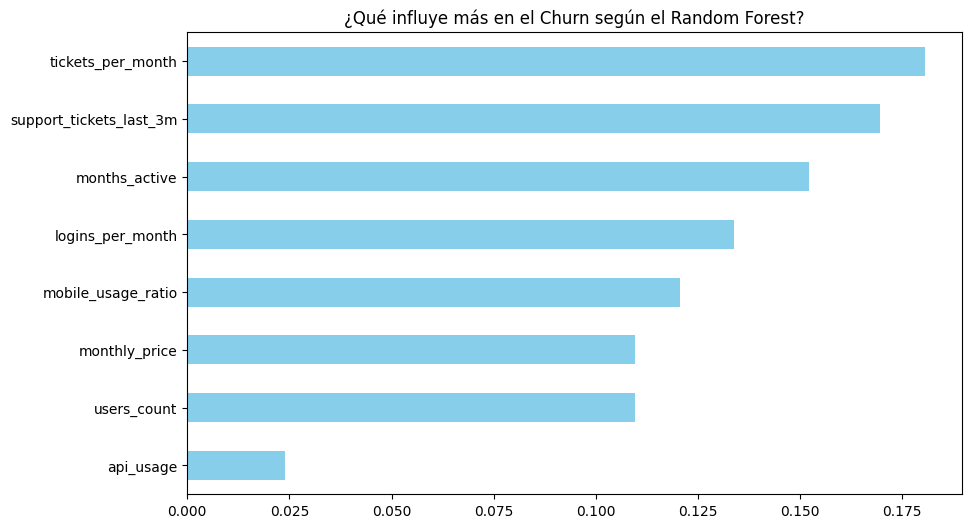

In [16]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', color='skyblue', figsize=(10,6))
plt.title('¿Qué influye más en el Churn según el Random Forest?')
plt.show()